# MBTI Analysis with Python

In [3]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import urllib.request
import re
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn

## Scraping the Web for Text Information

This part parses the front page of each subforum, and then extracts the text from the forum posts. 

The result looks like a TXT file for each type, with posts written inside, seperated by the three newlines.

In [6]:
gettype = r"\b[A-Z]{4}\b"
getpagenumber = r"-(\d*?)\.html"

webpages = ["http://personalitycafe.com/istj-forum-duty-fulfillers/", 
            "http://personalitycafe.com/intp-forum-thinkers/",
            "http://personalitycafe.com/isfj-forum-nurturers/",
            "http://personalitycafe.com/estj-forum-guardians/",
            "http://personalitycafe.com/esfj-forum-caregivers/",
            "http://personalitycafe.com/istp-forum-mechanics/",
            "http://personalitycafe.com/isfp-forum-artists/",
            "http://personalitycafe.com/estp-forum-doers/",
            "http://personalitycafe.com/esfp-forum-performers/",
            "http://personalitycafe.com/intj-forum-scientists/",
            "http://personalitycafe.com/entj-forum-executives/",
            "http://personalitycafe.com/entp-forum-visionaries/",
            "http://personalitycafe.com/infj-forum-protectors/",
            "http://personalitycafe.com/infp-forum-idealists/",
            "http://personalitycafe.com/enfj-forum-givers/",
            "http://personalitycafe.com/enfp-forum-inspirers/"]

def gettextfrompersonalitycaffee(webpage):
    page = urllib.request.urlopen(webpage)
    content = page.read()
    soup = BeautifulSoup(content, 'html.parser')
    allposts = soup.find_all("div", class_="content")
    users = soup.find_all("div", class_="userinfo")
    infos = zip(users, allposts)
    for user, post in infos:
        post = post.find_all("blockquote")[0]
        if "<script>" in post:
            post = post.script.decompose()
        post = post.get_text()
        pertype = re.search(gettype, user.get_text())
        if not pertype:
            continue
        pertype = pertype.group()
        with open(pertype, "a") as write:
            write.write(post)
            write.write("\n\n\n\n\n")
            
def getnumberofpages(webpage):
    page = urllib.request.urlopen(webpage)
    content = page.read()
    soup = BeautifulSoup(content, 'html.parser')
    numbers = soup.find_all("span", class_="first_last")
    if not numbers:
        return None
    link = numbers[-1].find_all("a")
    link = link[0].get("href")
    number = re.search(getpagenumber, link)
    number = number.group().replace(".html", "").replace("-", "")
    return int(number)

def getlinksfromfrontpage(webpage):
    allthreads = []
    page = urllib.request.urlopen(webpage)
    content = page.read()
    soup = BeautifulSoup(content, 'html.parser')
    threads = soup.find_all("h3", class_="threadtitle")
    for thread in threads:
        link = thread.find_all("a")
        link = link[0].get("href")
        allthreads.append(link)
    return allthreads

def getallthreadlinks(website, number):
    allwebsites = []
    if not number:
        return [website]
    for i in range(number):
        webpage = website.split(".")
        webpage[-2] = webpage[-2] + "-" + str(i + 1)
        webpage = ".".join(webpage)
        allwebsites.append(webpage)
    return allwebsites

for webpage in webpages:
    alllinks = getlinksfromfrontpage(webpage)
    for link in alllinks:
        number = getnumberofpages(link)
        if not number:
            allthreadlinks = [link]
        else:
            allthreadlinks = getallthreadlinks(link, number)
        for treadlink in allthreadlinks:
            gettextfrompersonalitycaffee(treadlink)
            break
        break
    break

## Cleaning the Data

Here I originally used vim:
    
    :%s/(function(w,d,s,i)/\r(function(w,d,s,i)/g 
    :g/(function(w,d,s,i)/d
        
I did not think it through how to do it in python yet.

## Making Analysis

In [1]:
filenames = ["ENFJ",
             "ENFP",
             "ENTJ",
             "ENTP",
             "ESFJ",
             "ESFP",
             "ESTJ",
             "ESTP",
             "INFJ",
             "INFP",
             "INTJ",
             "INTP",
             "ISFJ",
             "ISFP",
             "ISTJ",
             "ISTP"]

texts = list()
types = list()

for filename in filenames:
    with open(filename, "r") as read:
        content = read.readlines()
    content = "".join(content)
    content = content.split("\n\n\n")
    content = [post.strip() for post in content]
    for post in content:
        texts.append(post)
        types.append(filename)

In [4]:
#preparing data for building the model
data = [element for element in zip(texts, types)]
random.shuffle(data)
texts2 = [element[0] for element in data]
types2 = [element[1] for element in data]

number70 = int(round(len(texts2)*0.7,0))

texts_train = texts2[:number70]
types_train = types2[:number70]
texts_test = texts2[number70:]
types_test = types2[number70:]

In [5]:
#building the model
model = Pipeline([('vect', CountVectorizer(stop_words="english")),
                     ('tfidf', TfidfTransformer()),
                     ('svc', LinearSVC()),
                    ])

dtfitted = model.fit(texts_train, types_train)

0.479948548017


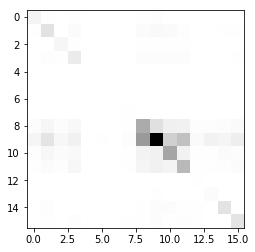

In [6]:
#this part is just how I checked if it is a good model -> usually it is better to check with a different dataset than the one used to build the model
predicted = dtfitted.predict(texts_test)
print(np.mean(predicted == types_test))
conf = sklearn.metrics.confusion_matrix(predicted, types_test)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()

In [7]:
#saving the model
joblib.dump(dtfitted, 'finalmodel.pkl') 

['finalmodel.pkl']